In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import bayessplicedmodels as bsm
from joblib import Parallel, delayed

# Lomax distribution

$X\sim\text{Pareto}(\alpha, \sigma)$ with pdf

$$
f(x) = \frac{\alpha \sigma^\alpha}{(\sigma +x)^{\alpha+1}}
$$

In [2]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Lomax":
            def logp(parms):
                α, σ = parms
                if np.all(parms) > 0:
                    return(len(X)*( np.log(α) + α * np.log(σ)) - (α + 1) * np.sum(np.log(X + σ)) )
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Lomax":
            def logp_body(X, parms,  γ):
                α, σ = parms
                F1 = 1 - σ**α * (γ + σ)**(-α)
                if np.all(parms) > 0 and F1 > 0:
                    return(len(X)*( np.log(α) + α * np.log(σ)) - (α + 1) * np.sum(np.log(X + σ)) - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                α, σ = parms
                F1 = 1 - σ**α * (γ + σ)**(-α)
                if np.all(parms) > 0 and F1 < 1:
                    
                    return(len(X)*( np.log(α) + α * np.log(σ)) - (α + 1) * np.sum(np.log(X + σ))  - len(X) * np.log(1 - F1))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Lomax":
            def logd(x):
                α, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(α))
                s = np.logical_and(α > 0, σ > 0)
                res[np.where(s)] = np.log(α[s]) + α[s] * np.log(σ[s]) - (α[s] + 1) * np.log(x + σ[s]) 
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_logds(self):
        if self.name == "Lomax":
            
            def logd_body(x, parms,  γ):
                α, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(α))
                s = np.logical_and(np.logical_and(α > 0, σ > 0), x < γ)
                res[np.where(s)] = np.log(α[s]) + α[s] * np.log(σ[s]) - (α[s] + 1) * np.log(x + σ[s]) - np.log(1 - σ[s]**α[s] * (γ[s] + σ[s])**(-α[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                α, σ = parms[:,0], parms[:,1]
                res = np.zeros(len(α))
                s = np.logical_and(np.logical_and(α > 0, σ > 0), x > γ)
                res[np.where(s)] = np.log(α[s]) + α[s] * np.log(σ[s]) - (α[s] + 1) * np.log(x + σ[s]) - np.log(σ[s]**α[s] * (γ[s] + σ[s])**(-α[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
    
    def set_cdf(self):
        if self.name == "Lomax":
            def cdf(parms, x):
                α, σ = parms
                return(1 - (σ / (x + σ))**α)
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Lomax":
            def pdf(parms, x):
                α, σ = parms
                return(α * σ**α / (x + σ)**(α + 1) )
        self.pdf = nb.jit(nopython = True)(pdf)
                
        
    def set_ppf(self):
        if self.name == "Lomax":
            def ppf(parms, y):
                α, σ = parms
                return( σ * ((1-y)**(-1 / α) - 1))
        self.ppf = ppf
        
    def sample(self, parms, n):
        if self.name == "Lomax":
            α, σ = parms
            return(st.lomax(α).rvs(size = n) * σ)

In [3]:
lomax_dist = loss_model("Lomax", ["α", "σ"])
print(lomax_dist.name, lomax_dist.parm_names, lomax_dist.d)
parms = np.array([1/2, 1/2])
α, σ = parms
x, y = 2, 0.5
lomax_dist.set_cdf(), lomax_dist.set_pdf(), lomax_dist.set_ppf()
lomax_dist.cdf(parms, x) - st.lomax(α).cdf(x / σ), lomax_dist.ppf(parms, y)-  st.lomax(α).ppf(y) * σ, lomax_dist.pdf(parms, x)-  st.lomax(α).pdf(x / σ) / σ 


Lomax ['α', 'σ'] 2


(1.1102230246251565e-16, 0.0, 1.3877787807814457e-17)

In [4]:
X, γ = st.lomax(α).rvs(size = 100) * σ, 2
lomax_dist.set_logps(), lomax_dist.set_logp(X)
print(lomax_dist.logp(parms) - np.sum(np.log(st.lomax(α).pdf(X / σ) / σ)))
print(lomax_dist.logp_body(X, parms, γ) -  np.sum(np.log(st.lomax(α).pdf(X / σ) / σ / st.lomax(α).cdf(γ / σ))))
print(lomax_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.lomax(α).pdf(X / σ) / σ / (1 - st.lomax(α).cdf(γ / σ)))))

5.684341886080802e-14
5.684341886080802e-14
5.684341886080802e-14


In [32]:
X = st.lomax(α).rvs(size = 10) * σ
α_prior, σ_prior, γ_prior= bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','σ', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_gamma_model = bsm.independent_priors([α_prior, σ_prior, γ_prior])
particle_cloud = prior_gamma_model.sample(20)
lomax_dist.set_logds(), lomax_dist.set_logd(particle_cloud.values)
α_vec, σ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1],particle_cloud.values[:,2]
print(np.array([np.log(st.lomax(α_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i]) for i in range(len(γ_vec))] - 
               lomax_dist.logd(X[0])))
print(lomax_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]) -
      np.array([np.sum(np.log(st.lomax(α_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / st.lomax(α_vec[i]).cdf(γ_vec[i] / σ_vec[i]))) 
                for i in range(len(γ_vec)) ]) )
print(lomax_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) - 
      np.array([np.sum(np.log(st.lomax(α_vec[i]).pdf(X[0] / σ_vec[i]) / σ_vec[i] / (1-st.lomax(α_vec[i]).cdf(γ_vec[i] / σ_vec[i])))) 
                for i in range(len(γ_vec)) ]) )

[ 2.22044605e-16  0.00000000e+00  0.00000000e+00  4.44089210e-16
  0.00000000e+00  0.00000000e+00  6.66133815e-16  0.00000000e+00
 -8.88178420e-16  2.22044605e-16  0.00000000e+00  0.00000000e+00
 -1.33226763e-15 -4.44089210e-16 -1.11022302e-15 -2.22044605e-16
 -6.66133815e-16  0.00000000e+00  0.00000000e+00 -4.44089210e-16]
[           -inf            -inf -2.22044605e-16            -inf
  1.11022302e-16            -inf -1.11022302e-15            -inf
  8.88178420e-16            -inf -2.22044605e-16            -inf
            -inf            -inf            -inf            -inf
            -inf  0.00000000e+00            -inf  4.44089210e-16]
[-3.33066907e-16  0.00000000e+00            -inf  8.32667268e-17
            -inf -2.22044605e-16            -inf -2.22044605e-16
            -inf -3.33066907e-16            -inf  0.00000000e+00
  1.11022302e-15  2.22044605e-16  8.88178420e-16  5.55111512e-16
  1.11022302e-15            -inf  0.00000000e+00            -inf]


In [71]:
α_prior, σ_prior, γ_prior= bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('fixed','σ', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_gamma_model = bsm.independent_priors([α_prior])
particle_cloud = prior_gamma_model.sample(20)
particles = particle_cloud.values
popSize, d = particles.shape
W = np.ones(popSize) / popSize 
W = np.random.dirichlet(np.ones(popSize), 1)[0]


In [72]:
cloud_cov = np.cov(particles, 
                           bias = False, 
                           aweights = W, 
                           rowvar = False) * 2.38 / np.sqrt(d)
step_size = np.diag(cloud_cov.reshape(d,d))
np.array([np.sum((particles[:,k]  - np.sum(particles[:,k] * W))**2 * W) for k in range(d)]) * 2.38 / np.sqrt(d) / (1 - np.sum(W**2)) , step_size


(array([0.55602746]), array([0.55602746]))

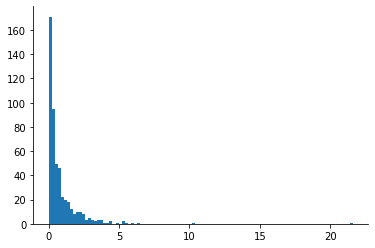

In [28]:
parms_true = np.array([2, 1])
f = loss_model("Lomax", ["α", "σ"])
X= f.sample(parms_true, 500)
plt.hist(X,bins=100)
sns.despine()
α_prior, σ_prior = bsm.prior_model('gamma','α', 1, 1), bsm.prior_model('gamma','σ', 1, 1)
prior_single_model = bsm.independent_priors([α_prior, σ_prior])

In [29]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_single_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma prior distribution
Generation: 1 ;temperature: 0.005753517150878906 ;ESS: 1000 ;steps:5 ;particle moved: 97.75%
Generation: 2 ;temperature: 0.030132530727769335 ;ESS: 999 ;steps:6 ;particle moved: 97.05%
Generation: 3 ;temperature: 0.12210467831353827 ;ESS: 999 ;steps:8 ;particle moved: 98.6%
Generation: 4 ;temperature: 0.44991021719086244 ;ESS: 1000 ;steps:9 ;particle moved: 98.65%
Generation: 5 ;temperature: 1.0 ;ESS: 1447 ;steps:9 ;particle moved: 99.05000000000001%
Wall time: 2.92 s


-368.4703307037321 722.0973052397503 730.0162754034578


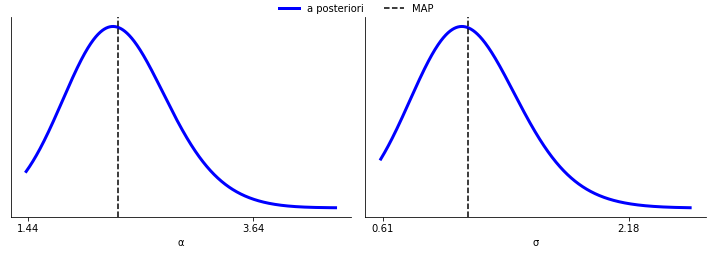

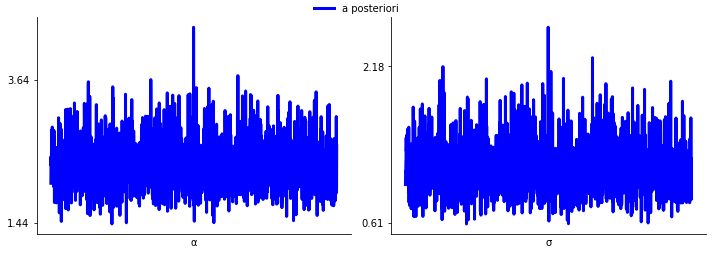

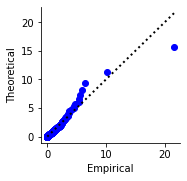

In [30]:
f.set_ppf()
print(log_marg, DIC, WAIC)
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

# In a composite model

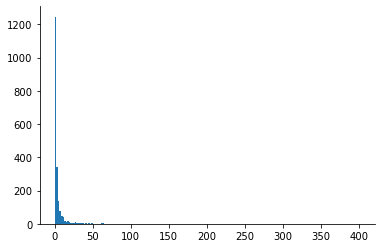

In [39]:
parms_true = np.array([2, 3,  1.5, 2, 3, 0.9])
f1, f2 =  loss_model("Lomax", ["α1", "σ1"]), loss_model("Lomax", ["α2", "σ2"])
f = bsm.spliced_loss_model(f1 , f2, "continuous") 
X= f.sample(parms_true, 2000) 
α1_prior, σ1_prior = bsm.prior_model('gamma','α1', 1, 1), bsm.prior_model('gamma','σ1', 1, 1)
α2_prior, σ2_prior = bsm.prior_model('gamma','α2',1, 1), bsm.prior_model('gamma','σ2', 1, 1)
γ_prior, p_prior =  bsm.prior_model('gamma','γ',1, 1), bsm.prior_model('beta', 'p', 2, 2)
prior_spliced_model = bsm.independent_priors([α1_prior,σ1_prior, α2_prior, σ2_prior, γ_prior])
plt.hist(X,bins=200)
sns.despine()


In [40]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 1000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-gamma prior distribution
Generation: 1 ;temperature: 0.0017919540405273438 ;ESS: 500 ;steps:3 ;particle moved: 100.0%
Generation: 2 ;temperature: 0.009253486255602184 ;ESS: 499 ;steps:3 ;particle moved: 99.9%
Generation: 3 ;temperature: 0.03171776936324587 ;ESS: 500 ;steps:3 ;particle moved: 99.6%
Generation: 4 ;temperature: 0.09688224173117176 ;ESS: 500 ;steps:3 ;particle moved: 99.5%
Generation: 5 ;temperature: 0.25415077394117025 ;ESS: 500 ;steps:3 ;particle moved: 99.0%
Generation: 6 ;temperature: 0.6044249947934666 ;ESS: 499 ;steps:3 ;particle moved: 98.5%
Generation: 7 ;temperature: 1.0 ;ESS: 781 ;steps:3 ;particle moved: 99.1%
Wall time: 7.07 s


-4072.1668239768233 8122.379436913319 8132.681857575036


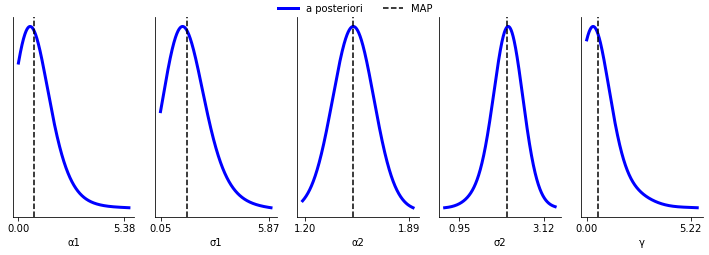

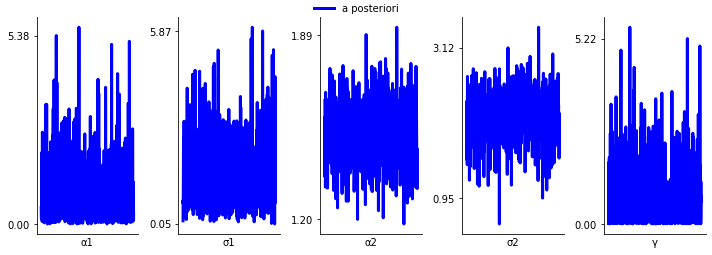

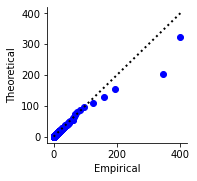

In [41]:
print(log_marg, DIC, WAIC)
f.set_ppf()
bsm.posterior_plots(f, trace)
bsm.trace_plots(f, trace)
bsm.qq_plot(X, f, trace.mean().values)

In [21]:
f.ppf(trace.mean().values, 0.1), f.cdf(trace.mean().values, 0.5)
# trace.mean().values

(99999999.99999928, 0.26955181147888785)

# On the danish dataset

In [27]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal"]
body_model_param_names = [['λ1'], ["r1", "m1"], ["k1", "β1"], ["μ1", "λ1"], ["μ1", "σ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [[bsm.prior_model('gamma',body_model_param_names[0][0], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[1][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[1][1], 1, 1)], 
                [bsm.prior_model('gamma',body_model_param_names[2][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[2][1], 1, 1)],
                [bsm.prior_model('gamma',body_model_param_names[3][0], 1, 1), bsm.prior_model('gamma',body_model_param_names[3][1], 1, 1)],
                [bsm.prior_model('normal',body_model_param_names[4][0], 0, 0.5), bsm.prior_model('gamma',body_model_param_names[4][1], 1, 1)]
]

# Model for the tail of the distribution
tail_model_names = ["Lomax"]
tail_model_param_names = [["α2", "σ2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [
                [bsm.prior_model('gamma',tail_model_param_names[0][0], 1, 1), bsm.prior_model('gamma',tail_model_param_names[0][1], 1, 1)]]
γ_prior, p_prior = bsm.prior_model('uniform', "γ", min(X), max(X)), bsm.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bsm.loss_model(body_model_names[i], body_model_param_names[i]), bsm.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bsm.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bsm.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))    
for f in fs:
    f.set_ppf()
fs_dict = dict(zip(f_names, fs))

In [25]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 4000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):     
        trace, log_marg, DIC, WAIC = bsm.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
        return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))


Wall time: 2min 9s


In [28]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bsm.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
3,Inverse-Gaussian-Lomax-continuous,5,0.973966,-3843.791321,7575.421020,7592.510336,0.999388,2.491000e+11
2,Weibull-Lomax-continuous,5,0.931939,-3851.815185,7630.728739,7651.179023,0.000327,2.491000e+11
1,Gamma-Lomax-continuous,5,0.932026,-3852.128639,7630.310985,7652.036725,0.000239,2.491000e+11
4,Lognormal-Lomax-continuous,5,0.933369,-3853.800790,7645.098536,7668.379678,0.000045,2.491000e+11
0,Exp-Lomax-continuous,4,1.802841,-4656.674100,9270.328489,9280.522461,0.000000,8.595079e+02


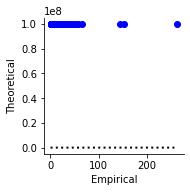

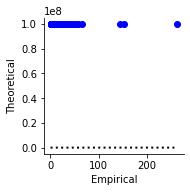

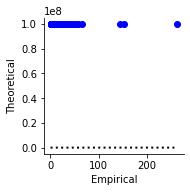

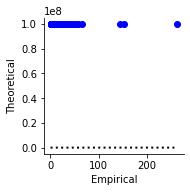

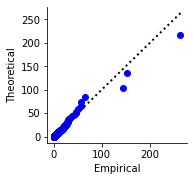

In [29]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bsm.posterior_plots(f, trace)
    # bsm.trace_plots(f, trace)
    bsm.qq_plot(X, f, trace.mean().values)
